In [12]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [13]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

In [147]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [148]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'alarm.bif'))
true_dgm.draw()

In [149]:
from scipy.special import digamma, gamma, gammaln, beta, betaln, polygamma, binom
from scipy.misc import derivative

In [150]:
def log_mbeta1(a, b):
    """ 
    ln(-beta'(a, b))
    """
    return betaln(a, b) + np.log(-digamma(a) + digamma(a + b))

def beta1(a, b):
    return -np.exp(log_mbeta1(a, b))

def log_beta2(a, b):
    """
    ln(beta"(a, b))
    """
    return betaln(a, b) + np.log((digamma(a) - digamma(a + b))**2 + (polygamma(1, a) - polygamma(1, a + b)))

def beta2(a, b):
    return np.exp(log_beta2(a, b))

In [151]:
def log_mvbeta(*alphas):
    return np.sum([gammaln(alpha) for alpha in alphas]) - gammaln(np.sum(alphas))

In [152]:
def log_betaderiv_xy(x, y):
    result1 = betaln(x, y)
    result1 += np.log(digamma(x + y) - digamma(x))
    result1 += np.log(digamma(x + y) - digamma(y))
    result1 = np.exp(result1)
    
    result2 = betaln(x, y)
    result2 += np.log(polygamma(1, x + y))
    result2 = -np.exp(result2)
    
    return result1 + result2

In [153]:
def log_beta_deriv(x, y, nx, ny):
    if nx < ny: 
        return log_beta_deriv(y, x, ny, nx)
    if nx == 0:
        return betaln(x, y), +1
    elif nx == 1 and ny == 0:
        return np.log(digamma(x + y) - digamma(x)) + betaln(x, y), -1
    elif nx == 2 and ny == 0:
        return np.log((digamma(x + y) - digamma(x)) ** 2 + (polygamma(1, x) - polygamma(1, x + y))) + \
            betaln(x, y), +1
    elif nx == 1 and ny == 1:
        return np.log((digamma(x + y) - digamma(x))*(digamma(x + y) - digamma(y)) - polygamma(1, x + y)) + \
            betaln(x, y), +1
    else:
        raise Exception("not implemented for nx={}, ny={}".format(nx, ny))

In [213]:
def beta_analytical_expectation1(alpha_x, alpha_y, m_x, k_x, m_y, k_y):
    val, sign = log_beta_deriv(alpha_x + k_x, alpha_y + k_y, m_x, m_y)
    return sign * np.exp(val - betaln(alpha_x, alpha_y))

In [214]:
def generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, m_x, k_x, m_y, k_y, n_z=0):
    #print alpha_x, alpha_y, alpha_z
    
    if alpha_z < 0.5:
        return beta_analytical_expectation1(alpha_x, alpha_y, m_x, k_x, m_y, k_y)
    
    result = 0.
    for i in range(m_y + 1):
        current = 0.
        sign = +1
        
        d1_log, d1_sign = log_beta_deriv(alpha_x + k_x, 
                                         alpha_y + alpha_z + n_z + k_y, 
                                         m_x, i)
        
        current += d1_log
        sign *= d1_sign
        
        d2_log, d2_sign = log_beta_deriv(alpha_y + k_y, alpha_z + n_z,
                                         m_y - i, 0)

        current += d2_log
        sign *= d2_sign
        
    
        current -= log_mvbeta(alpha_x, alpha_y, alpha_z)

        result += sign * np.exp(current) * binom(m_y, i)
    return result

def generic_analytical_expectation(alpha, m_x, k_x, m_y, k_y, x=0, y=1):
    alpha_x = alpha[x]
    alpha_y = alpha[y]
    alpha_z = np.sum(alpha) - alpha_x - alpha_y
    
    return generic_analytical_expectation1(alpha_x, alpha_y, alpha_z, m_x, k_x, m_y, k_y)

In [215]:
def analytical_covariance(alpha, x, y):
    return generic_analytical_expectation(alpha, 1, 1, 1, 1, x=x, y=y) - \
        (generic_analytical_expectation(alpha, 1, 1, 0, 0, x=x, y=y) * \
         generic_analytical_expectation(alpha, 0, 0, 1, 1, x=x, y=y))

In [216]:
def analytical_variance(alpha, x):
    y = (x + 1) % len(alpha)
    return generic_analytical_expectation(alpha, 2, 2, 0, 0, x=x, y=y) - \
        (generic_analytical_expectation(alpha, 1, 1, 0, 0, x=x, y=y)**2)

In [217]:
def entropy_variance_analytical(alpha):
    #print alpha
    result = 0.
    for i, alpha_i in enumerate(alpha):
        result += analytical_variance(alpha, i)
        #print 'cur:', result
    for i, alpha_i in enumerate(alpha):
        for j, alpha_j in enumerate(alpha):
            if i == j: continue
            result += analytical_covariance(alpha, i, j)
            #print 'cur:', result
    #print 'res:', result
    return result

In [218]:
from graphmodels import TableFactor
def s_discrete_entropy(x):
    def make_factor(data, arguments, leak=1e-9):
        factor = TableFactor(arguments, list(data.columns))
        factor.fit(data)
        factor.table += leak
        factor.normalize(*factor.scope, copy=False)
        return factor
    arguments = list(x.columns)
    factor_x = make_factor(x, arguments).normalize(*arguments)
    prob = factor_x.table.flatten()
    variance = entropy_variance_analytical((prob * x.shape[0]))
    return -np.sum(prob * np.log(prob)), variance

0.883424089383 0.0597252823139


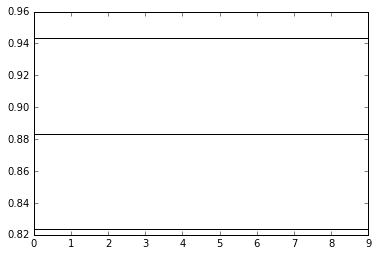

In [219]:
X = []
for i in range(1):
    data = true_dgm.rvs(size=1000)[['ERRCAUTER', 'HRSAT']]
    x, var_x = s_discrete_entropy(data)
    X.append(x)
plt.plot(X)
plt.hlines([np.mean(X), np.mean(X) + 1.96*np.sqrt(var_x), np.mean(X) - 1.96*np.sqrt(var_x)], 0, 9)
print x, 1.96*np.sqrt(var_x)

In [234]:
class s_EntropyEstimator:
    def __init__(self, graph, data):
        self.graph = graph
        self.data = data
        self.cache = {}

    def _footprint(self, nodes, n):
        return tuple(nodes) + (n,)

    def __call__(self, nodes, n):
        fp = self._footprint(nodes, n)
        if fp in self.cache:
            return self.cache[fp]

        if np.any(nodes):
            subdata = self.data[self.data.columns[nodes]]
            result = s_discrete_entropy(subdata.iloc[:n])
        else:
            result = 0, 0

        self.cache[fp] = result
        return result


class s_InformationEstimator:
    def __init__(self, graph, data):
        self.graph = graph
        self.entropy_estimator = s_EntropyEstimator(graph, data)
        self.chosen = []

    def __call__(self, node, parents, N):
        parents = np.array(parents, dtype=bool)
        h1, v_h1 = self.entropy_estimator(parents, N)
        temp = np.zeros(len(parents), dtype=bool)
        temp[node] = True
        h2, v_h2 = self.entropy_estimator(temp, N)
        parents[node] = True
        h12, v_h12 = self.entropy_estimator(parents, N)
        return h1 + h2 - h12, v_h1 + v_h12


class s_ScoreBIC:
    def __init__(self, graph, data):
        self.graph = graph
        self.data = data
        self.n_values = np.asarray([len(self.data[column].value_counts()) for column in self.data.columns])
        self.mi_estimator = s_InformationEstimator(graph, data)

    def __call__(self, node, parents, N=None):
        parents = np.asarray(parents, dtype=bool)
        k = self.n_values[node]*np.prod(self.n_values[parents]) - 1
        n = self.data.shape[0]
        l, v_l = self.mi_estimator(node, parents, N=N)
        l *= n
        v_l *= n**2
        
        result = l - 0.5 * np.log(n) * k
        return result, v_l

    def total(self, N):
        score = 0.
        variance = 0.
        for node in self.graph.nodes():
            pa = self.graph.adj[:, node].copy()
            cs, cv = self(node, pa, N)
            score += cs
            variance += cv
        return score, variance

In [235]:
data = true_dgm.rvs(10000)
score = s_ScoreBIC(gm.MatrixGraph.from_networkx_DiGraph(true_dgm, order=data.columns), data)

In [236]:
v = [False] * data.shape[1]
v[list(data.columns).index('ERRCAUTER')] = True
v[list(data.columns).index('BP')] = True

x, vx = score(list(data.columns).index('HRSAT'), v, 10000)
x, np.sqrt(vx)

(2317.5378603673244, 126.51564951901327)

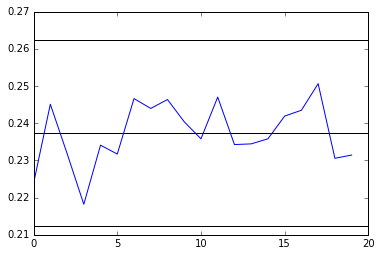

In [237]:
X = []
for i in range(20):
    data = true_dgm.rvs(10000)
    score = s_ScoreBIC(gm.MatrixGraph.from_networkx_DiGraph(true_dgm, order=data.columns), data)
    v = [False] * data.shape[1]
    v[list(data.columns).index('ERRCAUTER')] = True
    v[list(data.columns).index('BP')] = True

    #x, vx = score(list(data.columns).index('HRSAT'), v, 10000)
    x, vx = score.mi_estimator(list(data.columns).index('HRSAT'), v, 10000)
    X.append(x)
plt.plot(X)
plt.hlines([np.mean(X), np.mean(X) + 1.96*np.sqrt(vx), np.mean(X) - 1.96*np.sqrt(vx)], 0, 20)

In [238]:
from itertools import permutations
import networkx as nx
from graphmodels import DGM, MatrixGraph, InvalidOperation, LocalOperation
from graphmodels.information import get_eec, reset_eec
import matplotlib.pyplot as plt

class s_AddEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst

    def do(self):
        if self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 0
            raise InvalidOperation()
        return self

    def undo(self):
        self.graph.adj[self.src, self.dst] = 0
        return self

    def score(self, **kwargs):
        if self.graph.adj[self.src, self.dst]:
            return 0., 0.
        self.graph.adj[self.src, self.dst] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 0
            return 0., 0.
        self.graph.adj[self.src, self.dst] = 0
        
        pa = self.graph.adj[:, self.dst].copy()
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score = -val
        score_v = var

        pa[self.src] = 1        
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score += val
        score_v += var
        return score, score_v

    def __str__(self):
        return "s_AddEdge {}->{}".format(self.src, self.dst)
    

class s_RemoveEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst

    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        return self

    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        return self

    def score(self, **kwargs):
        if not self.graph.adj[self.src, self.dst]:
            return 0., 0.
        
        pa = self.graph.adj[:, self.dst].copy()
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score = -val
        score_v = var
        
        pa[self.src] = 0
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score += val
        score_v += var
        
        return score, score_v
    
    def __str__(self):
        return "s_RemoveEdge {}->{}".format(self.src, self.dst)


class s_ReverseEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst

    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        self.graph.adj[self.dst, self.src] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 1
            self.graph.adj[self.dst, self.src] = 0
            raise InvalidOperation()
        return self

    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        self.graph.adj[self.dst, self.src] = 0
        return self

    def score(self, **kwargs):
        if not self.graph.adj[self.src, self.dst]:
            return 0., 0.
        self.graph.adj[self.src, self.dst] = 0
        self.graph.adj[self.dst, self.src] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 1
            self.graph.adj[self.dst, self.src] = 0
            return 0., 0., 
        self.graph.adj[self.src, self.dst] = 1
        self.graph.adj[self.dst, self.src] = 0
        
        pa = self.graph.adj[:, self.dst].copy()
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score = -val
        score_v = var
        
        pa[self.src] = 0
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score += val
        score_v += var

        pa = self.graph.adj[:, self.src].copy()
        
        val, var = self.fscore(self.src, pa, **kwargs)
        score -= val
        score_v += var
        
        pa[self.dst] = 1
        
        val, var = self.fscore(self.src, pa, **kwargs)
        score += val
        score_v += var
        
        return score, score_v
    
    def __str__(self):
        return "s_ReverseEdge {}->{}".format(self.src, self.dst)


In [258]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'alarm.bif'))
true_dgm.draw()

In [262]:
data = true_dgm.rvs(1000)
graph = MatrixGraph.from_networkx_DiGraph(true_dgm, order=data.columns)
graph.adj[:, :] = False
score = s_ScoreBIC(graph, data)
print list(enumerate(data.columns))

[(0, 'ANAPHYLAXIS'), (1, 'DISCONNECT'), (2, 'TPR'), (3, 'INSUFFANESTH'), (4, 'LVFAILURE'), (5, 'HISTORY'), (6, 'HYPOVOLEMIA'), (7, 'STROKEVOLUME'), (8, 'INTUBATION'), (9, 'LVEDVOLUME'), (10, 'PCWP'), (11, 'FIO2'), (12, 'ERRLOWOUTPUT'), (13, 'MINVOLSET'), (14, 'VENTMACH'), (15, 'VENTTUBE'), (16, 'PULMEMBOLUS'), (17, 'SHUNT'), (18, 'ERRCAUTER'), (19, 'KINKEDTUBE'), (20, 'PRESS'), (21, 'CVP'), (22, 'VENTLUNG'), (23, 'MINVOL'), (24, 'VENTALV'), (25, 'ARTCO2'), (26, 'PVSAT'), (27, 'SAO2'), (28, 'CATECHOL'), (29, 'HR'), (30, 'HRBP'), (31, 'CO'), (32, 'BP'), (33, 'HRSAT'), (34, 'HREKG'), (35, 'EXPCO2'), (36, 'PAP')]


In [272]:
ae = s_AddEdge(graph, score, 1, 15)
val, var = ae.score(N=1000)
var = np.sqrt(var)
val, var

(141.27339095791712, 46.856070374764911)

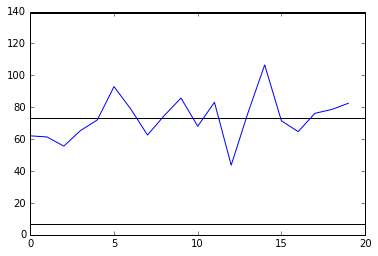

In [275]:
X = []
for i in range(20):
    data = true_dgm.rvs(500)
    graph = MatrixGraph.from_networkx_DiGraph(true_dgm, order=data.columns)
    graph.adj[:, :] = False
    score = s_ScoreBIC(graph, data)
    
    ae = s_AddEdge(graph, score, 1, 15)
    x, vx = ae.score(N=500)
    
    X.append(x)
plt.plot(X)
plt.hlines([np.mean(X), np.mean(X) + 1.96*np.sqrt(vx), np.mean(X) - 1.96*np.sqrt(vx)], 0, 20)

In [77]:
def max_until_success(opx, opy, Nx, Ny, Nmax, Nbatch, k=3):
    #print "BEGIN COMPARSION"
    #print opx
    #print opy
    cx, vx = opx.score(N=Nx)
    cy, vy = opy.score(N=Ny)
    while Nx < Nmax or Ny < Nmax:
        #print "iteration:", Nx, Ny, cx, cy
        #print "mean:", cy - cx
        #print "k*stddev:", k*np.sqrt(vx + vy)
        
        if cy - cx > k*np.sqrt(vx + vy):
            return opy, Ny, Nx
        elif cx - cy > k*np.sqrt(vx + vy):
            return opx, Nx, Ny
        if Nx <= Ny:
            Nx += Nbatch
            cx, vx = opx.score(N=Nx)
        else:
            Ny += Nbatch
            cy, vy = opy.score(N=Ny)
    #print "warning: insufficient data
    if cx >= cy:
        return opx, Nx, Ny
    else:
        return opy, Ny, Nx

In [78]:
def probmax1(ops, Ninit, Nbatch, Nmax, k=3):
    best_op = ops[0]
    N_best = Ninit
    for i, op in enumerate(ops[1:]):
        best_op, N_best, _ = max_until_success(best_op, op, N_best, Ninit, Nmax, Nbatch, k=k)
    return best_op

In [79]:
class s_GreedySearch:
    def __init__(self, data, cls_score, Ninit=100, Nbatch=None, k=3):
        graph = nx.DiGraph()
        graph.add_nodes_from(data.columns)
        graph = MatrixGraph.from_networkx_DiGraph(graph, order=data.columns)
        self.graph = graph
        self.fscore = cls_score(graph, data)
        
        self.Ninit = Ninit
        self.Nbatch = Nbatch
        self.Nmax = data.shape[0]
        self.k = k

        self.ops = []
        self.ops += [s_AddEdge(graph, self.fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [s_RemoveEdge(graph, self.fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [s_ReverseEdge(graph, self.fscore, u, v) for u, v in permutations(graph.nodes(), 2)]

    def iteration(self):
        # plt.hist([op.score() for op in self.ops], bins=50)
        op = probmax1(self.ops, self.Ninit, self.Nbatch, self.Nmax, self.k)
        if op.score(N=self.Nmax)[0] <= 1e-5:
            return True
        try:
            op.do()
            return False
        except InvalidOperation:
            return True

    def __call__(self, max_iter=40, verbose=True):
        #reset_eec()
        counter = 0
        while not self.iteration() and counter < max_iter:
            if verbose:
                print(self.fscore.total(self.Nmax)[0])
                #print('entropy evaluations:', get_eec())
            counter += 1
        return DGM(self.graph.to_networkx_DiGraph())

In [80]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'earthquake.bif'))
true_dgm.draw()

In [81]:
data = true_dgm.rvs(size=1000000)

In [82]:
from graphmodels import GreedySearch, ScoreBIC, AddEdge
gs = GreedySearch(data, ScoreBIC)

In [83]:
%%time
gs(max_iter=10).draw()

39360.5814934
entropy evaluations: 15
76350.9671013
entropy evaluations: 18
112404.349553
entropy evaluations: 20
133006.89744
entropy evaluations: 21
CPU times: user 5.54 s, sys: 88 ms, total: 5.63 s
Wall time: 5.63 s


In [386]:
from graphmodels import GreedySearch, ScoreBIC, AddEdge
gs = s_GreedySearch(data, s_ScoreBIC, Ninit=100, Nbatch=100000, k=1)

In [387]:
print data.columns

Index([u'Earthquake', u'Burglary', u'Alarm', u'MaryCalls', u'JohnCalls'], dtype='object')


In [388]:
%%time
gs(max_iter=1).draw()

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
40082.7452448
[[False False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
[[False False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
CPU times: user 12.4 s, sys: 48 ms, total: 12.4 s
Wall time: 12.4 s


In [360]:
print [(lambda x: (x[0], np.sqrt(x[1])))(op.score(N=gs.Nmax)) for op in gs.ops]

[(-13.592238765881795, 965.87632957264407), (13721.645295137912, 1049.6109828901206), (6833.8724637899904, 1086.7229504116083), (5460.2486080265671, 1177.7749750309347), (-13.592238765881795, 1012.8101754762095), (40117.284021164916, 960.54529295010093), (20190.180925653105, 1028.9873529265285), (19960.289896963295, 1118.3578797741252), (13721.645295137912, 1063.3664933915702), (40117.284021164916, 926.73889319132786), (37252.128660514107, 1056.2211520842795), (36712.772001498633, 1147.007657676128), (6833.8724637899904, 1083.0598628865662), (20190.180925653105, 978.77448914848287), (37252.128660514107, 1038.5518445847952), (16161.84597963876, 1185.9508016823681), (5460.2486080265671, 1134.073521087088), (19960.289896963295, 1028.0203495822427), (36712.772001498633, 1088.8206199026108), (16161.84597963876, 1146.0350203149301), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0,

In [339]:
gs.Nmax

1000000

In [362]:
op = probmax1(gs.ops, gs.Ninit, gs.Nbatch, gs.Nmax, k=1)

In [363]:
str(op)

's_AddEdge 0->1'